# This notebook is used to evaluate the performance of trained model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import os
from glob import glob
from pathlib import Path
from typing import List, Union

import yaml
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.metrics import classification_report
from collections import Counter

In [3]:
from ner_ehr.data.ehr import EHR
from ner_ehr.data.utils import df_to_namedtuples
from ner_ehr.utils import read_annotatedtuples, load_np
from ner_ehr.data.variables import AnnotationTuple

from ner_ehr.training.models import LitLSTMNERTagger
from ner_ehr.training.datasets import EHRDataset, EHRBatchCollator
from ner_ehr.data.vocab import TokenEntityVocab

In [4]:
LOG_DIR = "../logs/ner_ehr_lstm"
VERSION = 2
DEFAULT_DEVICE_TYPE = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu")
PROCESSED_DIR_TEST = "../processed/test"

hparams = yaml.safe_load(
    open(os.path.join(LOG_DIR, f"version_{VERSION}", "hparams.yaml")))

ckpt = glob(os.path.join(LOG_DIR, f"version_{VERSION}", "checkpoints", "*.ckpt"))[0]
ckpt

'../logs/ner_ehr_lstm/version_2/checkpoints/epoch=34-step=3289-val_loss=0.124.ckpt'

In [5]:
train_annotatedtuples = read_annotatedtuples(
    dir=hparams["parser_args"]["processed_data_dir_train"])

vocab = TokenEntityVocab(to_lower=True if hparams["parser_args"]["to_lower"]=="Y" else False)
vocab.fit(annotatedtuples=train_annotatedtuples)

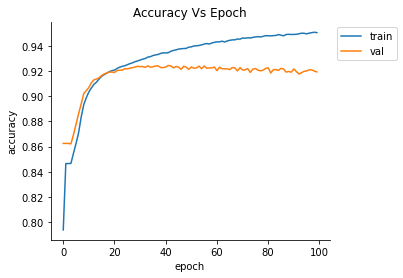

In [6]:
metrics = pd.read_csv(
    os.path.join(LOG_DIR, f"version_{VERSION}", "metrics.csv"),
    engine="python")

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(
    metrics[~metrics["train_acc_epoch"].isna()]["epoch"],
    metrics[~metrics["train_acc_epoch"].isna()]["train_acc_epoch"], 
    label="train")

ax.plot(
    metrics[~metrics["val_acc_epoch"].isna()]["epoch"],
    metrics[~metrics["val_acc_epoch"].isna()]["val_acc_epoch"], 
    label="val")
ax.legend(bbox_to_anchor=(1.01, 1.))
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy Vs Epoch")
sns.despine(ax=ax)
plt.show()

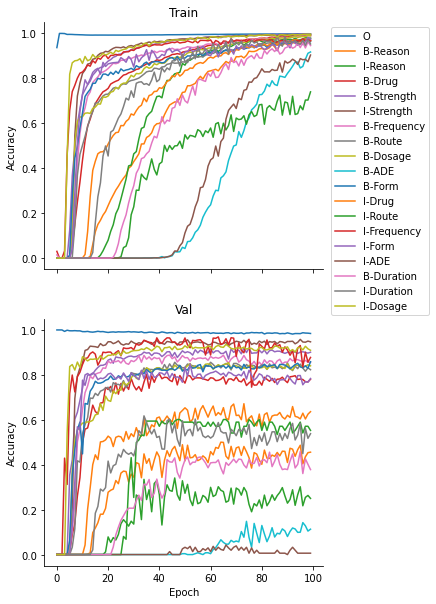

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(5, 10), sharex=True)
for col in metrics.columns:
    if "label=0" in col:
        continue
    if col.startswith("train_acc_label") and col.endswith("epoch"):
        entity = vocab.label_to_entity(int(col.split("=")[1].split("_")[0]))[0]
        ax1.plot(
            metrics[~metrics[col].isna()]["epoch"],
            metrics[~metrics[col].isna()][col], 
            label=entity)
    if col.startswith("val_acc_label") and col.endswith("epoch"):
        entity = vocab.label_to_entity(int(col.split("=")[1].split("_")[0]))[0]
        ax2.plot(
            metrics[~metrics[col].isna()]["epoch"],
            metrics[~metrics[col].isna()][col], 
            label=entity)
ax1.set_title("Train")
ax2.set_title("Val")
ax2.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Accuracy")
sns.despine(ax=ax1)
sns.despine(ax=ax2)
ax1.legend(bbox_to_anchor=(1.01, 1.))
plt.show()

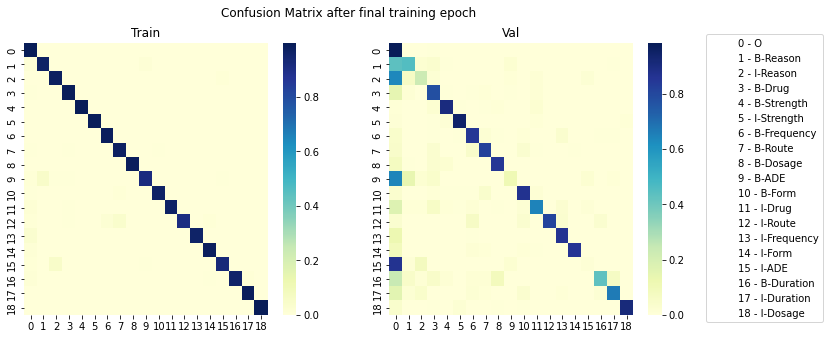

In [8]:
cm_train = load_np(
    os.path.join(LOG_DIR, f"version_{VERSION}", "train_cm_epoch=99.npy"))
cm_train = cm_train/cm_train.sum(axis=1, keepdims=True)
cm_val = load_np(
    os.path.join(LOG_DIR, f"version_{VERSION}", "val_cm_epoch=99.npy"))
cm_val = cm_val/cm_val.sum(axis=1, keepdims=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(cm_train[1:,1:], cmap="YlGnBu", ax=ax1)
ax1.set_title("Train")
sns.heatmap(cm_val[1:,1:], cmap="YlGnBu", ax=ax2)
ax2.set_title("Val")



legend_elements = []
for label, entity in vocab._label_to_entity.items():
    if label == 0:
        continue
    legend_elements.append(Line2D([0], [0], lw=0, label=f"{label-1} - {entity}"))
ax2.legend(handles=legend_elements, bbox_to_anchor=(1.8,1.05))
plt.suptitle(t="Confusion Matrix after final training epoch")
plt.show()

In [9]:
test_ds = EHRDataset(
    dir=PROCESSED_DIR_TEST, 
    vocab=vocab, 
    seq_length=hparams["parser_args"]["max_seq_len"], 
    annotated=True)

collate_fn = EHRBatchCollator(return_meta=True)
test_dl = DataLoader(
    dataset = test_ds, 
    collate_fn=collate_fn,
    batch_size=64, 
    shuffle=False)

In [10]:
lit_lstm = LitLSTMNERTagger(
    embedding_dim=hparams["embedding_dim"],
    vocab_size=hparams["vocab_size"],
    hidden_size=hparams["hidden_size"],
    num_classes=hparams["num_classes"],
    num_lstm_layers=hparams["num_lstm_layers"],
    lstm_dropout=hparams["lstm_dropout"],
    bidirectional=hparams["bidirectional"],
)

lit_lstm.load_state_dict(
    torch.load(
        ckpt, 
        map_location=DEFAULT_DEVICE_TYPE)["state_dict"],
)

<All keys matched successfully>

In [11]:
test_true = []
test_pred = []

for X, Y, Meta in tqdm(test_dl, leave=False, position=0):
    with torch.no_grad():
        Y_hat = lit_lstm(X)
        Y_hat = torch.argmax(
            torch.softmax(Y_hat, dim=-1),
            dim=-1)
        
    for x, meta, y_hat in zip(X, Meta, Y_hat):
        y_hat = vocab.label_to_entity(
            labels=y_hat[:len(meta)].tolist())
        
        test_true += [l for l in meta]
        test_pred += [l[:-1] + [i] for l, i in zip(meta, y_hat)]

In [12]:
df_test_true = pd.DataFrame(test_true, columns=AnnotationTuple._fields)
df_test_pred = pd.DataFrame(test_pred, columns=AnnotationTuple._fields)

In [13]:
print(classification_report(
    y_true=df_test_true["entity"].values, 
    y_pred=df_test_pred["entity"].values))

/home/mittal.nit/.conda/envs/ner_ehr/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mittal.nit/.conda/envs/ner_ehr/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ADE       0.00      0.00      0.00       672
    B-Dosage       0.90      0.83      0.86      2681
      B-Drug       0.77      0.76      0.76     10582
  B-Duration       0.75      0.35      0.48       378
      B-Form       0.93      0.85      0.89      4359
 B-Frequency       0.84      0.85      0.85      4012
    B-Reason       0.50      0.42      0.45      2590
     B-Route       0.80      0.79      0.79      3513
  B-Strength       0.91      0.88      0.89      4230
       I-ADE       0.00      0.00      0.00       498
    I-Dosage       0.96      0.95      0.95      5476
      I-Drug       0.60      0.63      0.61      1878
  I-Duration       0.67      0.66      0.66       602
      I-Form       0.88      0.90      0.89      2911
 I-Frequency       0.78      0.93      0.85      7996
    I-Reason       0.29      0.30      0.30      2085
     I-Route       0.90      0.44      0.59       257
  I-Strength       0.92    

/home/mittal.nit/.conda/envs/ner_ehr/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
counts = Counter()
for counter in tqdm(vocab.token_entity_freq.values(), position=0, leave=False):
    counts.update(counter)
counts

Counter({'O': 651605,
         'I-Frequency': 11804,
         'I-Reason': 2774,
         'B-Strength': 6093,
         'I-Drug': 2859,
         'I-Dosage': 7702,
         'B-Drug': 14709,
         'B-Dosage': 3856,
         'I-Strength': 5128,
         'I-ADE': 725,
         'I-Duration': 898,
         'I-Route': 341,
         'B-ADE': 910,
         'B-Reason': 3502,
         'B-Frequency': 5729,
         'I-Form': 4157,
         'B-Duration': 534,
         'B-Route': 4984,
         'B-Form': 6066})